In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
base_path = "/kaggle/input/augmented-enhanced-pcos/content/data/enhanced_data"
categories = ["infected", "notinfected"]

In [3]:
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)



In [4]:
df = pd.DataFrame({"image_path": image_paths, 
                   "label": labels})

In [5]:
df.head()

,image_path,label
0,/kaggle/input/augmented-enhanced-pcos/content/...,infected
1,/kaggle/input/augmented-enhanced-pcos/content/...,infected
2,/kaggle/input/augmented-enhanced-pcos/content/...,infected
3,/kaggle/input/augmented-enhanced-pcos/content/...,infected
4,/kaggle/input/augmented-enhanced-pcos/content/...,infected


In [6]:
df.tail()

,image_path,label
15387,/kaggle/input/augmented-enhanced-pcos/content/...,notinfected
15388,/kaggle/input/augmented-enhanced-pcos/content/...,notinfected
15389,/kaggle/input/augmented-enhanced-pcos/content/...,notinfected
15390,/kaggle/input/augmented-enhanced-pcos/content/...,notinfected
15391,/kaggle/input/augmented-enhanced-pcos/content/...,notinfected


In [7]:
df.shape

(15392, 2)

In [8]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [9]:
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

image_path    0
label         0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15392 entries, 0 to 15391
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  15392 non-null  object
 1   label       15392 non-null  object
dtypes: object(2)
memory usage: 240.6+ KB


In [12]:
df['label'].unique()

array(['infected', 'notinfected'], dtype=object)

In [13]:
df['label'].value_counts()

label
notinfected    9144
infected       6248
Name: count, dtype: int64

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

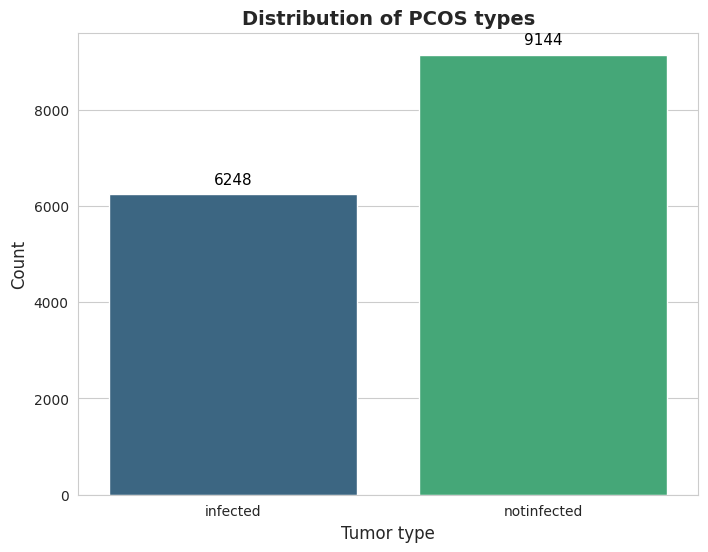

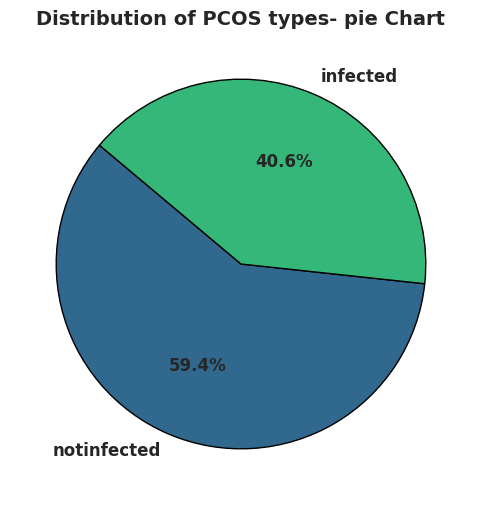

In [15]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of PCOS types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor type", fontsize=12)
ax.set_ylabel("Count",fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')
plt.show()



label_counts =df["label"].value_counts()

fig, ax = plt.subplots(figsize=(8,6))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
       startangle=140, colors=colors, textprops={'fontsize':12, 'weight':'bold'},
       wedgeprops={'edgecolor':'black', 'linewidth':1})
ax.set_title("Distribution of PCOS types- pie Chart", fontsize=14, fontweight='bold')

plt.show()

In [16]:
import cv2

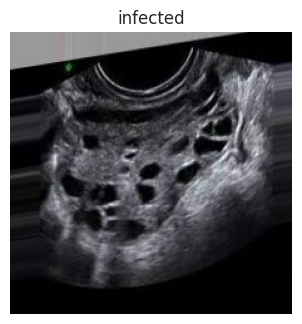

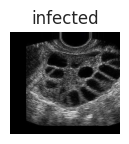

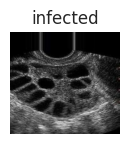

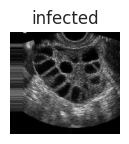

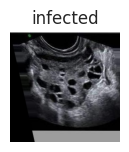

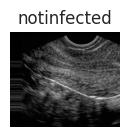

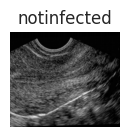

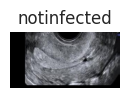

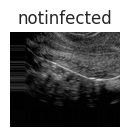

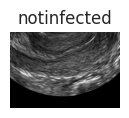

In [17]:
num_images = 5
plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label']== category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)
        plt.tight_layout()
        plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder

In [19]:
label_encoder = LabelEncoder()

df['category_encoded'] = label_encoder.fit_transform(df['label'])
df = df[['image_path', 'category_encoded']]

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[['image_path']], df['category_encoded'])

df_resampled = pd.DataFrame(X_resampled, columns=['image_path'])
df_resampled['category_encoded']= y_resampled

print("\nClass distribution after oversampling:")
print(df_resampled['category_encoded'].value_counts())





Class distribution after oversampling:
category_encoded
0    9144
1    9144
Name: count, dtype: int64


In [20]:
df_resampled

,image_path,category_encoded
0,/kaggle/input/augmented-enhanced-pcos/content/...,0
1,/kaggle/input/augmented-enhanced-pcos/content/...,0
2,/kaggle/input/augmented-enhanced-pcos/content/...,0
3,/kaggle/input/augmented-enhanced-pcos/content/...,0
4,/kaggle/input/augmented-enhanced-pcos/content/...,0
...,...,...
18283,/kaggle/input/augmented-enhanced-pcos/content/...,0
18284,/kaggle/input/augmented-enhanced-pcos/content/...,0
18285,/kaggle/input/augmented-enhanced-pcos/content/...,0
18286,/kaggle/input/augmented-enhanced-pcos/content/...,0


In [21]:
df_resampled['category_encoded']=df_resampled['category_encoded'].astype(str)

from sklearn.model_selection import train_test_split

train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size= 0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']
)
valid_df_new, test_df_new= train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded']
)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 16
img_size =(224, 224)
channels = 3
img_shape= (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

Found 14630 validated image filenames belonging to 2 classes.
Found 1829 validated image filenames belonging to 2 classes.
Found 1829 validated image filenames belonging to 2 classes.


In [23]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [24]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set for TensorFlow")
    except RuntimeError as e:
        print(e)

GPU is set for TensorFlow


In [31]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D

class ResBlock(layers.Layer):
     def __init__(self, filters, **kwargs):
         super(ResBlock, self).__init__(**kwargs)
         self.conv1 = layers.Conv2D(filters, 3, padding='same', activation='relu')
         self.bn1=layers.BatchNormalization()
         self.conv2=layers.Conv2D(filters, 3, padding='same')
         self.bn2=layers.BatchNormalization()
         self.relu=layers.ReLU()
     def call(self, inputs):
         residual = inputs
         x= self.conv1(inputs)
         x=self.bn1(x)
         x=self.conv2(x)
         x=self.bn2(x)
         x=layers.add([x, residual])
         return self.relu(x)

class ConvSequence(layers.Layer):
    def __init__(self, filters, **kwargs):
        super(ConvSequence, self).__init__(**kwargs)
        self.conv=layers.Conv2D(filters, 3,padding='same', activation='relu')
        self.bn=layers.BatchNormalization()
        self.maxpool=layers.MaxPool2D(3, strides=2, padding='same')
        self.resblock1=ResBlock(filters)
        self.resblock2=ResBlock(filters)
    def call(self, inputs):
         x= self.conv(inputs)
         x=self.bn(x)
         x=self.maxpool(x)
         x=self.resblock1(x)
         x=self.resblock2(x)
         return x
class ImpalaCNN(tf.keras.Model):
    def __init__(self, base_filters=16, width_scale=1, **kwargs):
        super(ImpalaCNN, self).__init__(**kwargs)
        filters=[base_filters * width_scale, 2 * base_filters * width_scale, 
                 2* base_filters * width_scale]
        self.conv_seq1 = ConvSequence(filters[0])
        self.conv_seq2 = ConvSequence(filters[1])
        self.conv_seq3 = ConvSequence(filters[2])
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.linear1=layers.Dense(256, activation='relu')
        self.dropout=layers.Dropout(0.5)
        self.linear2=layers.Dense(1, activation='sigmoid')
    def call(self, inputs):
        x= self.conv_seq1(inputs)
        x= self.conv_seq2(x)
        x= self.conv_seq3(x)
        x=self.global_avg_pool(x)
        x=self.linear1(x)
        x=self.dropout(x)
        return self.linear2(x)


model = ImpalaCNN(base_filters=16, width_scale=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=5,
    batch_size=batch_size
)

Epoch 1/5
915/915 ━━━━━━━━━━━━━━━━━━━━ 69s 62ms/step - accuracy: 0.8204 - loss: 0.3073 - val_accuracy: 0.9431 - val_loss: 0.0913
Epoch 2/5
915/915 ━━━━━━━━━━━━━━━━━━━━ 51s 55ms/step - accuracy: 0.9453 - loss: 0.0984 - val_accuracy: 0.9590 - val_loss: 0.1013
Epoch 3/5
915/915 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.9603 - loss: 0.0812 - val_accuracy: 0.9880 - val_loss: 0.0196
Epoch 4/5
915/915 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.9951 - loss: 0.0184 - val_accuracy: 0.9218 - val_loss: 0.3115
Epoch 5/5
915/915 ━━━━━━━━━━━━━━━━━━━━ 50s 54ms/step - accuracy: 0.9935 - loss: 0.0173 - val_accuracy: 1.0000 - val_loss: 1.8367e-04


In [32]:
test_loss, test_accuracy = model.evaluate(test_gen_new)
print(f"Test Loss:{test_loss}")
print(f"TestAccuracy: {test_accuracy}")

115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 1.0000 - loss: 6.1633e-04
Test Loss:0.00034491668338887393
TestAccuracy: 1.0


In [33]:
y_pred = model.predict(test_gen_new)
y_pred = (y_pred > 0.5).astype(int)

115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step


In [34]:
y_ture = test_gen_new.labels

from sklearn.metrics import confusion_matrix, classification_report

conf_matrix = confusion_matrix(y_pred, y_ture)
print('Confusion matrix:')
print(conf_matrix)

Confusion matrix:
[[450 465]
 [465 449]]


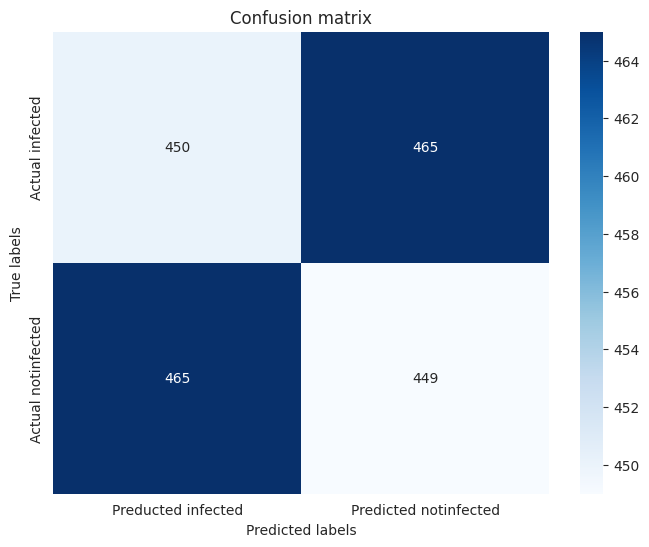

In [35]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt ='d', cmap='Blues',
            xticklabels=['Preducted infected', 'Predicted notinfected'],
            yticklabels=['Actual infected','Actual notinfected'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix')
plt.show()

In [36]:
class_report = classification_report(y_ture, y_pred, target_names=['infected', 'notinfected'])
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    infected       0.49      0.49      0.49       915
 notinfected       0.49      0.49      0.49       914

    accuracy                           0.49      1829
   macro avg       0.49      0.49      0.49      1829
weighted avg       0.49      0.49      0.49      1829

